# Learning with example
---

This tutorial introduces the fundamental concepts of FunctionalFilet through self-contained examples.

At its core, FunctionalFilet provides two main features:

    A semi-recurrent neural network constructor from a directed graph.
    A learning algorithm coupling gradient descent and structural optimization by the evolution of a graph.

We will use a problem of fitting $y=\sin(x)$ with a third order polynomial as our running example. The network will be trained with gradient descent and graph evolution algorithm to fit random data by minimizing the Euclidean distance between the network output and the true output.

## 1 - Import model
---

In this part we will import the model in python and check some properties during the import.

In [1]:
# import package
from functionalfilet import model as ff
import torch

model = ff.FunctionalFilet(train_size=1e5, TYPE="regress")

[INFO] Starting System...
[INFO] Calculation type : cuda
[INFO] Generate selection parameters for population..
[INFO] Generate first evolutionnal neural networks..
[INFO] ENN Generated!
[INFO] Generate training parameters for population..
[INFO] Generate evolution variable for population..
[INFO] Model pre-created!


The model creates several networks in parallel, the first is a control layer without a graph builder. See the model parameters with the *help* function. To see the composition of the two layers, we do:

In [2]:
#help(ff.FunctionalFilet) : __init__(self, io=(64,16), batch=25, nb_gen=100, nb_seed=9, alpha=0.9, train_size=1e6, NAMED_MEMORY=None, TYPE="class", INVERT=False, DEVICE=True, TIME_DEPENDANT = False, GDchain="standard", lossF = "standard", metrics='standard', multiprocessing=False)
print(model.SEEDER_LIST[0],'\n', model.SEEDER_LIST[1])

EvoNeuralNet(
  (enn_block): CTRL_NET(
    (IN): Conv1d(64, 64, kernel_size=(1,), stride=(1,), groups=64)
    (H1): Linear(in_features=64, out_features=16, bias=True)
    (H2): Linear(in_features=16, out_features=16, bias=True)
    (OUT): Linear(in_features=16, out_features=16, bias=True)
  )
) 
 EvoNeuralNet(
  (enn_block): pRNN(
    (Layers): ModuleList(
      (0): Linear(in_features=61, out_features=16, bias=True)
      (1): Sequential(
        (0): Linear(in_features=117, out_features=13, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=12, out_features=25, bias=True)
        (1): ReLU()
      )
      (3): Sequential(
        (0): Linear(in_features=4, out_features=5, bias=True)
        (1): ReLU()
      )
      (4): Sequential(
        (0): Linear(in_features=1, out_features=1, bias=True)
        (1): ReLU()
      )
      (5): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
      )
      (6)

Note that the parallel neural networks contain "enn_block" layers with inputs of 64 neurons and 16 output neurons. Now we are going to build input/outputs of a different size to what is written in the network, and we are going to train it to fit the desired function in the next part.

In [3]:
## function to approximate
f = lambda x : torch.sin(x)
X = torch.linspace(0,10,100)[None]
y = f(X)

If you have 2D data output (or more), the model vectorizes the data for training, so we go from [batch, D1,D2] -> [batch, D1*D2]. Thus, it is necessary to reshape the output predicted by the model.

## 2 - Train model
---
In this part, we will train the model in python so that it fits a simple function. We will verify the changes induced in the model.

In [4]:
# training in one line
model.fit(X,y)

[INFO] Your dataset I/O is : (1, (100, 100))
[INFO] Your dataset contains less than min sample per generation. Data augmentation is : 1000
[INFO] Apply IO modification if undefined..
[INFO] Contruct Dataset formats..
[INFO] Launch evolution algorithm with SGD !


100%|██████████| 100/100 [20:05<00:00, 12.06s/it]


[INFO] Save model...
[INFO] The model its saved !


The training of the model is long, but it should be noted that each "evolutionary" network only receives *train_size/nb_gen = 1000 samples* per generation for a convergence problem. In addition we have several networks in parallel to solve this problem. We can check the structure of the networks as before:

In [5]:
print(model.SEEDER_LIST[0],'\n', model.SEEDER_LIST[1])

EvoNeuralNet(
  (enn_block): CTRL_NET(
    (IN): Conv1d(64, 64, kernel_size=(1,), stride=(1,), groups=64)
    (H1): Linear(in_features=64, out_features=16, bias=True)
    (H2): Linear(in_features=16, out_features=16, bias=True)
    (OUT): Linear(in_features=16, out_features=16, bias=True)
  )
  (patch_in): Sequential(
    (0): Conv1d(100, 64, kernel_size=(2,), stride=(2,), padding=(2,))
    (1): Dropout(p=0.9)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (patch_out): Sequential(
    (0): ReLU()
    (1): Conv1d(16, 100, kernel_size=(6,), stride=(6,), padding=(6,))
    (2): ReLU()
    (3): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  )
  (fc): Linear(in_features=100, out_features=100, bias=True)
) 
 EvoNeuralNet(
  (enn_block): pRNN(
    (Layers): ModuleList(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1)

We note that the model has created 2 additional blocks so that the evolutionary structure is compatible with the data. It is the *checkIO* function of the model which is responsible for this modification. To see the structure of the network, we do:

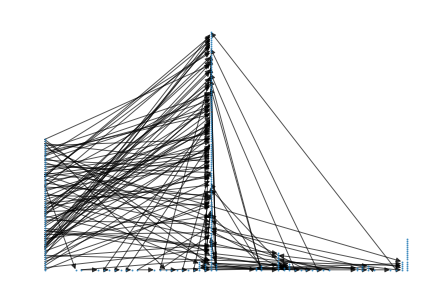

In [6]:
# finalist model
model.SEEDER_LIST[1].graph.SHOW_GRAPH(LINK_LAYERS = False)

## 3 - Manipulate model
---

In this part, we will see the result obtained and some possible manipulation.

In [7]:
y_ctrl = model.predict(X, index=0, numpy=True)
y_pred = model.predict(X, index=1, numpy=True)

# training data to numpy
x_array = X.detach().numpy().squeeze()
y_array = y.detach().numpy().squeeze()

[INFO] Switch to inference mode for model:0
[INFO] Switch to inference mode for model:1


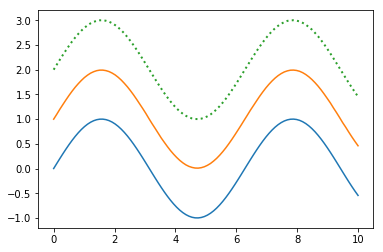

In [8]:
import pylab as plt
# data
plt.plot(x_array, y_array, label='true')
# control (classic)
plt.plot(x_array, y_ctrl[0]+1, label='ctrl')
# evolution
plt.plot(x_array, y_pred[0]+2, ':', lw=2, label='enn')

With this example, we can understand how to use the algorithm for more complex problems. The code being completely in Python, you can do your own test, change the code for your problems, do not hesitate to contact me in this case at <fabien.furfaro@gmail.com>.

### Supplementary
---

For more examples, look at the files contained in the example folder of the Github project :

- functionalfilet/
    - branding/
    - dist/
    - doc/
    - **example/**
        - uat_regression.py
        - blob_classification.py
        - gym_RL-CartPole-v0.py
    - functionalfilet/
    - README.rst
    - requirements.txt
    - setup.py

**Attention**, in these examples, the parameters of the models are not fully optimized for learning. For that, you have to play with the **train_size**, **nb_seeder** and **batch** parameters so that the model learns better from the input data. You can also increase the sample size of the dataset in case of overfitting or even change the optimization functions.

#### Load complete model

In [ ]:
model = ff.FunctionalFilet()

path = os.path.expanduser('~')+'/Saved_Model/ff_' + load_name
model.load(path)

#### Using custom gradient descent algorithm

*Applicable also for loss function and test metrics.*

In [ ]:
# build your own function
def SGDoptimizer(model_parameter, learning_rate=0.01, m=0.9) :
    return torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=m)

# put in model initialization
model = ff.FunctionalFilet(GDchain=SGDoptimizer)

#### Using one nn model with parameter

*See the structure of load method in model code*

In [1]:
from functionalfilet import ENN_net as ffnn

ffmodel = ffnn.EvoNeuralNet(EvoNeuralNet(self.IO, self.BATCH, self.DEVICE, control=ckpt.CONTROL, graph=True, net=(self.IO, ckpt.GRAPH, ckpt.LIST_C)))
ffmodel.checkIO(*RealIO)
ffmodel.load_state_dict(ckpt.NETWORKS)

#### Optimization proposition

For now, the code it's only written in python and the constructor of graph it's not time optimized. For that, it's better to use AutoGrad with static method :

```python

class pRNNFunction(Function):
    @staticmethod
    def forward(ctx, input, weights, bias, old_h, old_cell):
        """ Calculation """
        return new_h, new_cell

    @staticmethod
    def backward(ctx, grad_h, grad_cell):
        """ Calculation """
        return d_input, d_weights, d_bias, d_old_h, d_old_cell

class pRNN(nn.Module):
    def __init__(self, input_features, state_size):
        super(LLTM, self).__init__()
        self.weights = nn.Parameter(
            torch.Tensor(3 * state_size, input_features + state_size))
        self.bias = nn.Parameter(torch.Tensor(1, 3 * state_size))

    def forward(self, input, state):
        return LLTMFunction.apply(input, self.weights, self.bias, *state)
```

With this baseline, you can easily convert python code to C++ extension. For now, see https://github.com/fabienfrfr/pRNN_cppext (work in progress)

Also, you have https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html for adding some classic optimization.